# Customer Churn Prediction with PySpark MLlib

In this lab, we will build a machine learning pipeline using PySpark's MLlib to predict customer churn.

We will use the [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) dataset from Kaggle, which contains various features about customers that might influence churn.


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, when
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Step 1: Initializing Spark Session

We start by initializing a Spark session.

In [2]:
spark = SparkSession.builder \
    .appName("customer-churn-prediction") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/17 20:59:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Step 2: Loading the Dataset

Next, we load the [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) dataset from a CSV file.

This dataset includes various features such as customer demographics, account information, and services subscribed to by the customers.

In [3]:
TELCO_DATA = "../data/telco/customer-churn.csv"

data = spark.read.csv(TELCO_DATA, header=True, inferSchema=True)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

## Step 3: Data Preprocessing

### 3.1 Handling Non-Numeric Values in `TotalCharges`

First, we need to address any non-numeric values in the **TotalCharges** column and convert them to a numerical type.
Additionally, we have to remove all rows with **null** values.

In [4]:
data = data.withColumn("TotalCharges", 
                       when(regexp_replace(col("TotalCharges"), r"^[0-9]+(\.[0-9]+)?$", col("TotalCharges")).isNull(), None)
                       .otherwise(col("TotalCharges")))

data = data.withColumn("TotalCharges", col("TotalCharges").cast("double"))
data = data.dropna(subset=["TotalCharges"])


data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_25439/2461438079.py:2: SyntaxWarning: invalid escape sequence '\.'
  when(regexp_replace(col("TotalCharges"), "^[0-9]+(\.[0-9]+)?$", col("TotalCharges")).isNull(), None)


### 3.2 Handling Categorical Features

We use `StringIndexer` to convert categorical variables into numerical format. This includes features like: 

<div style="display: flex; justify-content: space-between;">

<div style="flex: 1; padding: 10px;">
  <ul>
    <li>gender</li>
    <li>Partner</li>
    <li>Dependents</li>
    <li>PhoneService</li>
    <li>MultipleLines</li>
  </ul>
</div>

<div style="flex: 1; padding: 10px;">
  <ul>
    <li>InternetService</li>
    <li>OnlineSecurity</li>
    <li>OnlineBackup</li>
    <li>DeviceProtection</li>
    <li>TechSupport</li>
  </ul>
</div>

<div style="flex: 1; padding: 10px;">
  <ul>
    <li>StreamingTV</li>
    <li>StreamingMovies</li>
    <li>Contract</li>
    <li>PaperlessBilling</li>
    <li>PaymentMethod</li>
  </ul>
</div>

</div>

To illustrate the preprocessing, let's take the `gender` feature as an example. 

| gender | genderIndexed |
|--------|---------------|
| Female | 0             |
| Male   | 1             |

In [5]:
indexer = StringIndexer(
    inputCols=[
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'], 
    outputCols=[
    'genderIndexed', 'PartnerIndexed', 'DependentsIndexed', 'PhoneServiceIndexed', 'MultipleLinesIndexed', 
    'InternetServiceIndexed', 'OnlineSecurityIndexed', 'OnlineBackupIndexed', 'DeviceProtectionIndexed', 
    'TechSupportIndexed', 'StreamingTVIndexed', 'StreamingMoviesIndexed', 'ContractIndexed', 
    'PaperlessBillingIndexed', 'PaymentMethodIndexed']
)

### 3.3 Assembling Features

We use `VectorAssembler` to combine all feature columns into a single vector column named `features`.

For each row, the values from *MonthlyCharges*, *TotalCharges*, *genderIndexed*, and others are concatenated in order to form the feature vector.


#### Why Use VectorAssembler?

- **Uniform Input Format:** Machine learning algorithms in Spark MLlib require input data to be in the form of a single vector of features. VectorAssembler helps in combining multiple feature columns into this required format.

- **Pipeline Compatibility:** It ensures compatibility with the Spark MLlib pipeline, where all feature transformations are applied in sequence before training the model.

- **Efficiency:** It consolidates the feature columns into a single vector, which can be processed more efficiently by Spark's distributed computing framework.


| id |features             |
|----|---------------------|
| 0  |[18.0,1.0,0.0,5000.0]|
| 1  |[20.0,0.0,1.0,6000.0]|
| 2  |[30.0,1.0,0.0,7000.0]|
| 3  |[40.0,0.0,1.0,8000.0]|

In [6]:
assembler = VectorAssembler(
    inputCols=[
        'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'genderIndexed', 'PartnerIndexed', 
        'DependentsIndexed', 'PhoneServiceIndexed', 'MultipleLinesIndexed', 'InternetServiceIndexed', 
        'OnlineSecurityIndexed', 'OnlineBackupIndexed', 'DeviceProtectionIndexed', 'TechSupportIndexed', 
        'StreamingTVIndexed', 'StreamingMoviesIndexed', 'ContractIndexed', 'PaperlessBillingIndexed', 
        'PaymentMethodIndexed'],
    outputCol='features'
)

### 3.4 Standardizing Features

We use `StandardScaler` to standardize the feature values.

Standardization is a preprocessing step in machine learning where features are rescaled so that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.

#### Why Standardize?

- **Normalization:** Ensures that all features contribute equally to the model, preventing features with larger scales from dominating the learning process.

- **Performance:** Many machine learning algorithms (e.g., linear regression, logistic regression, k-means) perform better or converge faster when features are on a similar scale.

- **Stability:** Helps in numerical stability, particularly for gradient-based optimization algorithms.

#### How Features are Standardized

The StandardScaler in PySpark MLlib standardizes features by subtracting the mean and dividing by the standard deviation of each feature. Mathematically, for a feature $x$:

$z = \frac{x - \mu}{\sigma}$

where:
- $x$ is the original feature value.
- $\mu$ is the mean of the feature.
- $\sigma$ is the standard deviation of the feature.
- $z$ is the standardized feature value.

In [7]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

### 3.5 Selecting the Target Variable or Label

We select the target variable, which is `Churn` in this case.
We ensure that only rows with Churn values of Yes or No are kept.
Then, we convert the Churn column to a binary format where Yes is mapped to 1.0 and No is mapped to 0.0.

In [8]:
data = data.filter((col('Churn') == 'Yes') | (col('Churn') == 'No'))
data = data.withColumn('label', when(col('Churn') == "Yes", 1.0).otherwise(0.0))

## Step 4: Splitting the Data

We split the dataset into training and test sets to allow for model training and evaluation.

In [9]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

## Step 5: Initializing the RandomForestClassifier

We initialize a random forest classifier, which will be used to predict customer churn.

In [10]:
classifier = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='label')

## Step 6: Creating a Parameter Grid

We create a parameter grid for hyperparameter tuning, allowing us to experiment with different values for the number of trees and the maximum depth of the trees.

In [11]:
param_grid = ParamGridBuilder() \
    .addGrid(classifier.numTrees, [10, 20, 30]) \
    .addGrid(classifier.maxDepth, [5, 10, 15]) \
    .build()

## Step 7: Initializing the Evaluator

We use a binary classification evaluator to evaluate the performance of the model based on the area under the ROC curve (AUC).

In [12]:
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction')

## Step 8: Initializing the CrossValidator

We use cross-validation to perform hyperparameter tuning and model evaluation.

In [13]:
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

## Step 9: Creating and Fitting the Pipeline

We create a pipeline that includes the preprocessing steps, the random forest classifier, and the cross-validator. The model is then fitted to the training data.

In [14]:
pipeline = Pipeline(stages=[indexer, assembler, scaler, crossval])

model = pipeline.fit(train_data)

24/06/17 20:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1011.4 KiB
24/06/17 20:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1242.4 KiB
24/06/17 20:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1464.4 KiB
24/06/17 20:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1651.4 KiB
24/06/17 20:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1793.3 KiB
24/06/17 20:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1106.9 KiB
24/06/17 20:59:16 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/06/17 20:59:17 WARN DAGScheduler: Broadcasting large task binary with size 1058.0 KiB
24/06/17 20:59:17 WARN DAGScheduler: Broadcasting large task binary with size 1480.1 KiB
24/06/17 20:59:18 W

## Step 10: Making Predictions and Evaluating the Model

We make predictions on the test set and evaluate the model using the AUC metric.

In [15]:
predictions = model.transform(test_data)

auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.7280415837507719


## Step 11: Displaying Feature Importance

We extract and plot the feature importances to understand which features are most influential in predicting customer churn.

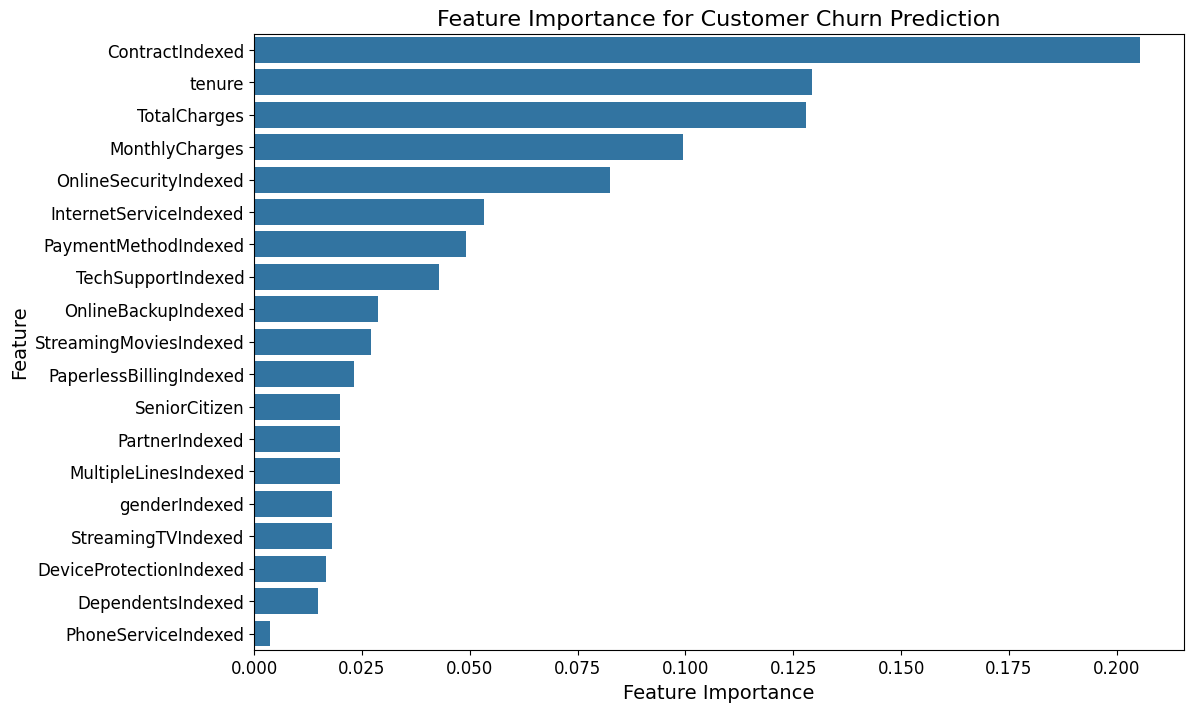

In [16]:
rf_model = model.stages[-1].bestModel
feature_importances = rf_model.featureImportances.toArray()

features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'genderIndexed', 'PartnerIndexed', 
            'DependentsIndexed', 'PhoneServiceIndexed', 'MultipleLinesIndexed', 'InternetServiceIndexed', 
            'OnlineSecurityIndexed', 'OnlineBackupIndexed', 'DeviceProtectionIndexed', 'TechSupportIndexed', 
            'StreamingTVIndexed', 'StreamingMoviesIndexed', 'ContractIndexed', 'PaperlessBillingIndexed', 
            'PaymentMethodIndexed']

feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance for Customer Churn Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Step 12: Closing the Spark Session

Finally, we close the Spark session to release resources.

In [17]:
spark.stop()